# Project Description:


## Data source for Vesuvius Challenge: https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/overview

- This Data Source is suitable for the project because it defines the project. This data is directly from the competition hosts for us to use and try to work with in order to increase the legibility of the papyrus scrolls. 

## size = 37.02 GB

files = 340

### From the competition website

Files
[train/test]/[fragment_id]/surface_volume/[image_id].tif slices from the 3d x-ray surface volume. Each file contains a greyscale slice in the z-direction. Each fragment contains 65 slices. Combined this image stack gives us width * height * 65 number of voxels per fragment. You can expect two fragments in the hidden test set, which together are roughly the same size as a single training fragment. The sample slices available to download in the test folders are simply copied from training fragment one, but when you submit your notebook they will be substituted with the real test data.

[train/test]/[fragment_id]/mask.png — a binary mask of which pixels contain data.

train/[fragment_id]/inklabels.png — a binary mask of the ink vs no-ink labels.

train/[fragment_id]/inklabels_rle.csv — a run-length-encoded version of the labels, generated using this script. This is the same format as you should make your submission in.

train/[fragment_id]/ir.png — the infrared photo on which the binary mask is based.

sample_submission.csv, an example of a submission file in the correct format. You need to output the following file in the home directory: submission.csv. See the evaluation page for information.


## Data source for Handwritten Greek Letters: https://www.kaggle.com/datasets/katianakontolati/classification-of-handwritten-greek-letters

- This Data Source is suitable for the project because it is used to make a Handwritten Greek Letter Classifier 2D Convolutional Neural Network which can in theory take inputs from the outputs of the Ink Detection Neural Network and classify those outputs as a particular Greek letter. This aids me in cleaning the final image, as I can use this second network to help increase the pixel values that are the most shared with the letter it is trying to predict. 

## size = 23 MB

files =

    train = 240
    
    test = 96

### From the website

Content
The training dataset consists of 240 images of Greek letters (10 for each letter). The test dataset consists of 96 images (4 for each letter). We provide both the grayscale original high-resolution images in 2 zip files (train and test) and the low-resolution images (14x14 pixels) used for the classification in another 2 zip files (train and test). Finally, matrices that correspond to each low-resolution (14x14) image are given in 2 .csv files (train and test). Numbers in cells represent the grayscale intensities.

The last column in both .csv files contains the labels/ ground truth, that is the 24 different letters. Each letter corresponds to a number in a way that it is explained below:

Letter Symbols => Letter Labels
α=>1, β=>2, γ=>3, δ=>4, ε=>5, ζ=>6, η=>7, θ=>8, ι=>9, κ=>10,
λ=>11, μ=>12, ν=>13, ξ=>14, ο=>15, π=>16, ρ=>17, σ=>18, τ=>19, υ=>20,
φ=>21, χ=>22, ψ=>23, ω=>24

In summary we have:

1. The original high-resolution images
(train _high _resolution.zip, test _high _resolution.zip)

2. The low-resolution (14x14) images
(train _letters _images.zip, test _letters _images.zip)

3. Training dataset
Grayscale intensities- with 240 rows/data, 196 columns/features, column 197 contains the labels (train.csv)

4. Test dataset
Grayscale intensities- with 96 rows/data, 196 columns/features, column 197 contains the labels (test.csv)

Tip: Only the .csv files are needed for the classification, the images are for illustration purposes.

## Inclusion of features justification

#### Vesuvius Challenge Dataset

I include these 10 slices in this position in the z axis of the papyrus scrolls because according to others online who are also competing, these are the only relevant slices with enough ink worth going through. Other slices are excluded according to this code:

BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction

Also, I did a lot of image processing I discuss further in the notebook and used Kuwahara versions of the raw data to train the model, decreasing training time significantly. 

#### Handwritten Greek Letters Dataset

I reformatted the original .csv table the data comes with to make it useable. I opted to select the high resolution images for my training data and scaled them dowm to 66 * 66 using datagen. I found a hard time teaching the network with the base model using the base 14 * 14 images. Greek letters are extremely hard to classify becuase many of them look similar or have complex forms, which is why I only used the higher resolution images for the final model. 

## Data Limitations 

The Vesuvius Challenge dataset is considerably large, with a size of 37.02 GB, which leads to issues with data storage and processing. The availability of only two fragments in the hidden test set limits the robustness of the developed model. 

The Handwritten Greek Letters dataset has a very small number of training and test images, which results in a failure to converge due to some overfitting and poor generalization performance. Finally, the use of high resultion images increased training and rendering time making it hard to perfect both Neural Networks at once. 


# Modeling

#### Vesuvius Challenge Dataset

In this project I iterated improving on the base Vesuvius Challenge Model by making the network more normalized with Dropouts, Batch Normalization, MaxPooling, Dense Layers, various optimizers, and different learning rates. I added batch normalization and dropouts first, which did not work well together, followed by adding dense layers. I found that image pre-processing combined with batch normalization and only dropouts on certain layers helped the most. Adding Dense layers did not change anything. In the end our model only kept some changes, but is definetly an improvement upon the base model. I am able to generate a comparable image with 1/3 of the training time. I tried optimizers such as Adadelta, Adamax, and RMSprop but the SGD optimizer performed the best for this task.

Baseline Vesuvius Model:

model = nn.Sequential(
    nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Flatten(start_dim=1),
    nn.LazyLinear(128), nn.ReLU(),
    nn.LazyLinear(1), nn.Sigmoid()
).to(DEVICE)

The first section of this notebook is adapted from the starting code needed to render the data, package it for use in the Ink Detection Neural Network, and package the final output file for submission to the competition. This open source tutorial was a great starting point for this project I am citing the source here: https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial

Of course I made modifications wherever I could make improvements, but this saved me a lot of data preprocessing and postprocessing work and let me focus on optimizing the network and output instead via image processing and the Letter Classifer AI. 

#### Handwritten Greek Letters Dataset

The Handwritten Greek Letters dataset, also obtained from Kaggle is used to make a secondary Handwritten Greek Letter Classifier 2D Convolutional Neural Network. I use the high-resolution images of the training data and scale them for the model.

I started with a very simple neural network as a base model, the same one commonly used on the MNIST dataset. Something like this:

model = Sequential()
model.add(Dense(hidden_units, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

        https://www.kaggle.com/code/prashant111/mnist-deep-neural-network-with-keras


One of the first things I did was adding in 2D convolutions, which significantly helped. Once I optimized the depth and density of the network, I optimized the convoutional filters to their optimal state. The final model I created appears to score very low, but in fact was useful enough to prove my concept might work if given more time and resources. The reason it scores so low is the datagen parameters I set are very variable to the images, and distort them a lot. First I discovered my model was tuned with much less rigorous datagen parameters when it was scoring 80% roughly. Then i stopped moving the filters and optimizers, and instead make the dataset much harder for it. This worked out well in the end, as it works well enough to show that my overlay technique may be useful. I tried optimizers such as Adadelta, Adamax, and RMSprop, but Adam worked the best. 

## Conclusion

This notebook serves as a proof of concept for some ideas worth exploring further for the Vesuvius Challenge. I demonstrate that image enhancement techniques can be applied to improve the outputs from the Ink Detection AI, improving upon the base model. I then show how a second AI can use those processed outputs to predict on live data as well and superimpose its best estimate over the original image. This can be used further to isolate intersects between sets, boost the relevant values, and then reprocessed to generate the final letter. I hope this advances the efforts of the Vesuvius Challenge Team and increases the legibility of the letters by detecting ink where it should be present in the papyrus. 

# Imports

In [49]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.utils.data as data # listed but used later to not confuse the two data packages

# NumPy and Pandas
import numpy as np
import pandas as pd

# Scikit-image for image processing
from skimage import data
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint
from skimage.morphology import reconstruction
from skimage.exposure import rescale_intensity

# Scikit-image for morphological operations
from skimage.morphology import (square, rectangle, diamond, disk, cube,
                                octahedron, ball, octagon, star)

# Matplotlib for plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# tqdm for progress bars
from tqdm import tqdm

import glob

# IPython widgets for interactive plots
from ipywidgets import interact, fixed

# Scikit-learn for data preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# OpenCV for computer vision
import cv2

# Other image processing libraries
from pykuwahara import kuwahara
from PIL import Image
from skimage import color

#### Set parameters for the model to use, including image paths, dimensions for 3D, and other params for the model. Only 10 slices in the z axis are relevant.

Since this dataset is so large, I will be only working with a small portion of it, a single letter P. We will still be using the remainder of the fragment, this is done to limit the render time of the model output, which takes very long. This way, I was able to iterate and refine more often. 

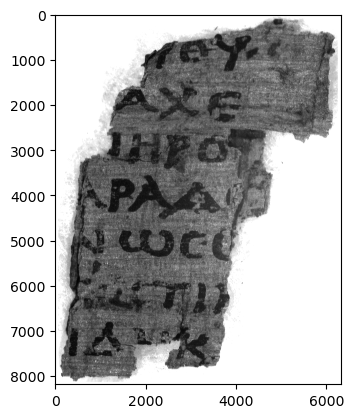

In [50]:
PREFIX = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/data/train/1/'
FILTERED_PATH = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/data/train/t1_kuwahara_slices/'
BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
TRAINING_STEPS = 10000
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.imshow(Image.open(PREFIX+"ir.png"), cmap="gray");

#### Display the mask and ink labels which will be used as ground truth for training.

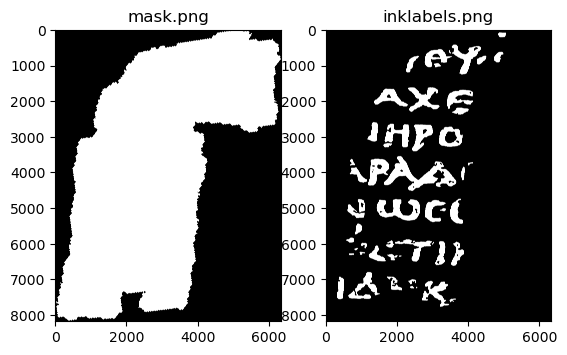

In [51]:
mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

#### Visualize the relevant slices that contain the most ink according to research. We will be running a 3d convolutional neural network over these slices, which are huge image files. 

I used this code to preprocess each slice and find the edges to make training faster.

In [52]:
# path_img = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/vesuvius_challenge/vesuvius-challenge-ink-detection/train/1/surface_volume/'

# for i in range(Z_START, Z_START+Z_DIM):
#     image = cv2.imread(path_img + str(i) + '.tif')
#     filt1 = kuwahara(image, method='mean', radius=3)
    
#     cv2.imwrite(str(i) + '.tif', filt1)

100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


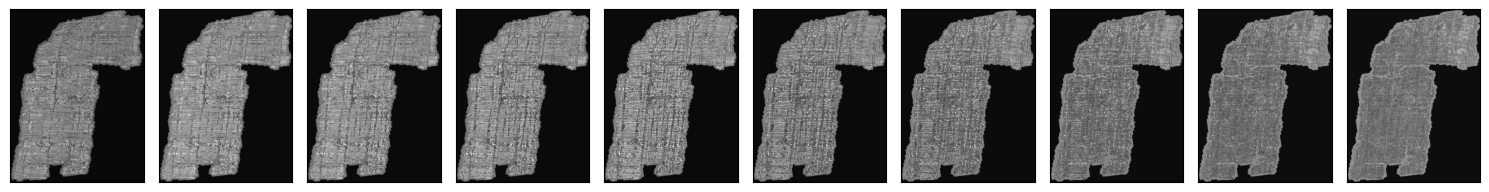

In [53]:
# Load the 3d x-ray scan, one slice at a time
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)

fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for image, ax in zip(images, axes):
  ax.imshow(np.array(Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
  ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

We are only going to focus on the small rectangle surrounding the letter P since the images are so large and this is only a proof of concept. I isolate the rectangle and use it later in the code as part of the rendering constraints.

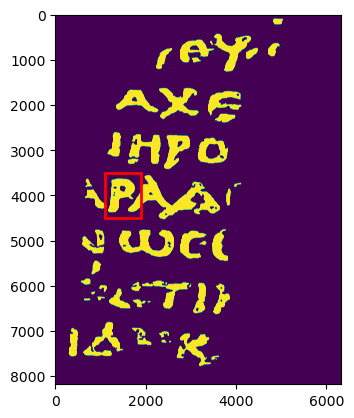

In [54]:
rect = (1100, 3500, 800, 1000)
fig, ax = plt.subplots()
ax.imshow(label.cpu())
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

Here we define a 3D convolutional neural network using the filtered slices. I am using batch normalization, max pooling, and dropouts as well. 

In [55]:
import torch.utils.data as data
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel

model = nn.Sequential(
    nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.BatchNorm3d(16),
    nn.Conv3d(16, 16, 3, 1, 1), nn.Dropout(0.2),
    nn.BatchNorm3d(16),
    nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.BatchNorm3d(32),
    nn.Conv3d(32, 32, 3, 1, 1), nn.Dropout(0.2),
    nn.BatchNorm3d(32),
    nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.BatchNorm3d(64),
    nn.Conv3d(64, 64, 3, 1, 1), nn.Dropout(0.2),
    nn.BatchNorm3d(64),
    nn.Flatten(start_dim=1),
    nn.LazyLinear(128), nn.ReLU(),
    nn.LazyLinear(1), nn.Sigmoid()
).to(DEVICE)

/opt/homebrew/Caskroom/miniforge/base/envs/capri/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


This code defines the training set: we are rendering the rectange from training on everything else outside of it. I commented out the training because we can load in the model. It will take about an hour to run. 

In [56]:
print("Generating pixel lists...")
# Split our dataset into train and val. The pixels inside the rect are the 
# val set, and the pixels outside the rect are the train set.
pixels_inside_rect = []
pixels_outside_rect = []
for pixel in zip(*np.where(mask == 1)):
    if pixel[1] < BUFFER or pixel[1] >= mask.shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= mask.shape[0]-BUFFER:
        continue # Too close to the edge
    if pixel[1] >= rect[0] and pixel[1] <= rect[0]+rect[2] and pixel[0] >= rect[1] and pixel[0] <= rect[1]+rect[3]:
        pixels_inside_rect.append(pixel)
    else:
        pixels_outside_rect.append(pixel)

# print("Training...")
# train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
# train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# criterion = nn.BCELoss()
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
# model.train()
# # running_loss = 0.0
# for i, (subvolumes, inklabels) in tqdm(enumerate(train_loader), total=TRAINING_STEPS):
#     if i >= TRAINING_STEPS:
#         break
#     optimizer.zero_grad()
#     outputs = model(subvolumes.to(DEVICE))
#     loss = criterion(outputs, inklabels.to(DEVICE))
#     loss.backward()
#     optimizer.step()
#     scheduler.step()
# #     running_loss += loss.item()
# #     if i % 3000 == 3000-1:
# #         print("Loss:", running_loss / 3000)
# #         running_loss = 0.0


Generating pixel lists...


save model

In [57]:
# torch.save(model.state_dict(), '3d_CNN_model.pth')

load model

In [58]:
model.load_state_dict(torch.load('/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/model/3D_CNN_model/3d_CNN_model.pth'))

<All keys matched successfully>

#### This renders the image, takes an hour to run on my computer. We already have the image saved so it is commented out. 

100%|██████████| 25057/25057 [1:20:19<00:00,  5.20it/s]


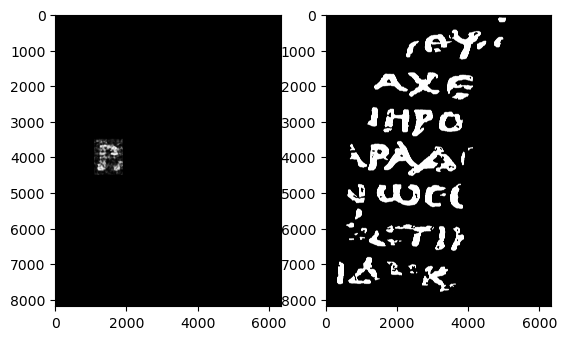

In [59]:
eval_dataset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
output = torch.zeros_like(label).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        for j, value in enumerate(model(subvolumes.to(DEVICE))):
            output[pixels_inside_rect[i*BATCH_SIZE+j]] = value

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

Define a threshold to denoise the output, reducing it allows more noise to pass through.

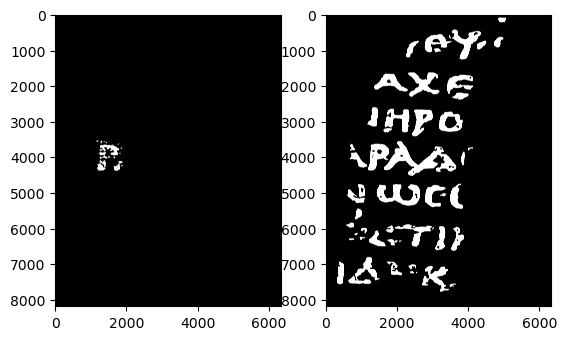

In [60]:
THRESHOLD = 0.4
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.gt(THRESHOLD).cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

This is the output needed for the competition. I go a step further to see how can image processing help the output look stronger. 

In [61]:
def rle(output):
    flat_img = np.where(output.flatten().cpu() > THRESHOLD, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))
rle_output = rle(output)
# This doesn't make too much sense, but let's just output in the required format
# so notebook works as a submission. :-)
print("Id,Predicted\na," + rle_output + "\nb," + rle_output, file=open('submission.csv', 'w'))

print(rle_output)

22358818 1 22371392 1 22371394 3 22371398 5 22371408 1 22377722 13 22377736 13 22384055 1 22384059 1 22384068 1 22384074 3 22384105 23 22384130 1 22384132 1 22384134 5 22384142 2 22390385 2 22390389 6 22390396 5 22390404 5 22390438 1 22396714 11 22396728 2 22403049 5 22403058 1 22403060 1 22403064 1 22409375 1 22409426 19 22415705 6 22422032 13 22422047 5 22428361 29 22434691 14 22434710 2 22434715 1 22434750 3 22434754 3 22434758 7 22434798 1 22441020 23 22447347 25 22453680 27 22453708 2 22453717 4 22460011 10 22460022 2 22460031 1 22460035 1 22460039 1 22460046 6 22460110 11 22460125 5 22460134 1 22466340 14 22466360 3 22466365 1 22466374 9 22466463 1 22472666 35 22472703 10 22472786 10 22472870 5 22478996 48 22479117 1 22479119 7 22479192 14 22479233 1 22485327 48 22485438 1 22485443 26 22491657 52 22491775 21 22497984 57 22498105 20 22498190 5 22498580 12 22498594 2 22498598 1 22498606 1 22504314 20 22504336 34 22504436 20 22504519 6 22504551 6 22504887 2 22504910 7 22510645 16 22

save the output image

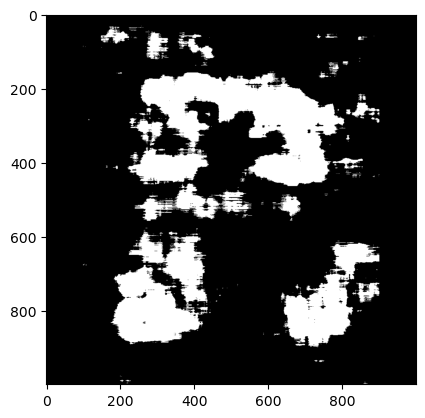

In [89]:
plt.imshow(output.gt(THRESHOLD).cpu()[3500:4500, 1000:2000], cmap='gray');
# plt.savefig('output_image.jpg', bbox_inches='tight')

In [63]:
image_orig = np.array(output.gt(THRESHOLD).cpu())

mask = []
for i in range(0,len(image_orig)):
    mask_layer = [1 if 'False' else 0 for x in image_orig[i]]
    mask.append(mask_layer)
mask = np.array(mask)
mask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

Here I test out a proof of concept using various image distortion and reconstruction methods. This was a playground where I then learned how to string together the image processing functions to get a cleaner end output.

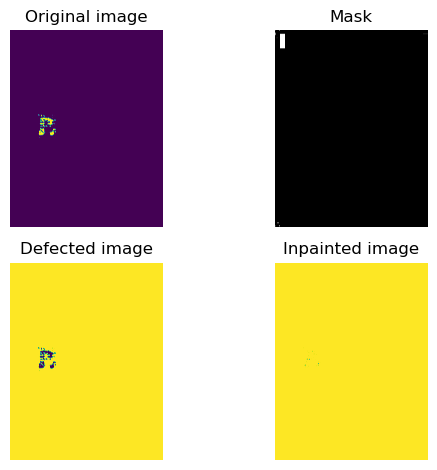

In [64]:
mask = []
for i in range(0,len(image_orig)):
    mask_layer = [0 if 'False' else 1 for x in image_orig[i]]
    mask.append(mask_layer)

mask = np.array(mask)

# Create mask with six block defect regions
mask[20:60, 0:20] = 1
mask[30:60, 170:195] = 1
mask[-60:-30, 170:195] = 1
mask[200:800, 200:400] = 1
mask[-180:-160, 70:155] = 1
mask[-60:-20, 0:20] = 1

# add a few long, narrow defects
mask[200:205, -200:] = 1
mask[150:255, 20:23] = 1
mask[365:368, 60:130] = 1

image_defect = image_orig * ~mask[...]

# image_result = inpaint.inpaint_biharmonic(image_defect, mask)

# Rescale image intensity so that we can see dim features.
image_orig = rescale_intensity(image_orig, in_range=(0, 20))

seed = np.copy(image_orig)
seed[1:-1, 1:-1] = image_orig.max()
mask_local = image_orig

filled = reconstruction(seed, mask_local, method='erosion', footprint=square(3))

seed = np.copy(image_orig)
seed[1:-1, 1:-1] = image_orig.min()
rec = reconstruction(seed, mask_local, method='dilation', footprint=square(3))


# image_result = skimage.morphology.remove_small_holes(image_orig, area_threshold=500, connectivity=100)

fig, axes = plt.subplots(ncols=2, nrows=2)
ax = axes.ravel()

ax[0].set_title('Original image')
ax[0].imshow(image_orig)

ax[1].set_title('Mask')
ax[1].imshow(mask, cmap=plt.cm.gray)

ax[2].set_title('Defected image')
ax[2].imshow(image_defect)

ax[3].set_title('Inpainted image')
ax[3].imshow(image_orig - filled)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

# Letter Classifier AI

I am setting the paths to the relevant images for the neural network and for evaluation. This letter classifier can help us further improve the outputs from the first model. Ideally, the network can approximate the correct letter at the very least, and when overlayed with the original image, it should not be very wrong. I think this method if refined, can help increase the first model's RLE scores since it would correct the image. 

In [103]:
img_dir_test = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/test_letters_images/'
img_dir_high_test = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/test_high_resolution/'
img_dir_train = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/train_letters_images/'
img_dir_high_train = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/train_high_resolution/'
img_path = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/test_high_resolution/letter_bnw_test_65.jpg'
batch_size = 24

Here I am cleaning the data so it is formatted correctly using pandas. I am going to feed it 24 classes and the corresponding letters in high resolution then scaled down to 66*66. Each class is the letter it represents. For my model 0 is 1 and 23 is 24; I shifted the index down one unit. 

Letter Symbols => Letter Labels
α=>1, β=>2, γ=>3, δ=>4, ε=>5, ζ=>6, η=>7, θ=>8, ι=>9, κ=>10,
λ=>11, μ=>12, ν=>13, ξ=>14, ο=>15, π=>16, ρ=>17, σ=>18, τ=>19, υ=>20,
φ=>21, χ=>22, ψ=>23, ω=>24

In [104]:
train_df = pd.read_csv('/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/train.csv', header=None)
train_df

info_path_train = pd.DataFrame(train_df[196])
info_path_train["ID"] = info_path_train.index + 1
info_path_train["External ID"] = ['letter_bnw_' + str(x) + '.jpg' for x in info_path_train["ID"]]
info_path_train["Description"] = info_path_train[196]
info_path_train['Description'] = [x for x in info_path_train['Description'].sort_values(ascending=False)]
info_path_train["Description"] = [int(x-1) for x in info_path_train["Description"]]
info_path_train = info_path_train.drop(columns=['ID', 196])
info_path_train

,External ID,Description
0,letter_bnw_1.jpg,23
1,letter_bnw_2.jpg,23
2,letter_bnw_3.jpg,23
3,letter_bnw_4.jpg,23
4,letter_bnw_5.jpg,23
...,...,...
235,letter_bnw_236.jpg,0
236,letter_bnw_237.jpg,0
237,letter_bnw_238.jpg,0
238,letter_bnw_239.jpg,0


In [105]:
test_df = pd.read_csv('/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/test.csv', header=None)


info_path_test = pd.DataFrame(test_df[196])
info_path_test["ID"] = info_path_test.index + 1
info_path_test["External ID"] = ['letter_bnw_test_' + str(x) + '.jpg' for x in info_path_test["ID"]]
info_path_test["Description"] = info_path_test[196]
info_path_test["Description"] = [int(x-1) for x in info_path_test["Description"]]
info_path_test = info_path_test.drop(columns=['ID', 196])
info_path_test

,External ID,Description
0,letter_bnw_test_1.jpg,0
1,letter_bnw_test_2.jpg,0
2,letter_bnw_test_3.jpg,0
3,letter_bnw_test_4.jpg,0
4,letter_bnw_test_5.jpg,1
...,...,...
91,letter_bnw_test_92.jpg,22
92,letter_bnw_test_93.jpg,23
93,letter_bnw_test_94.jpg,23
94,letter_bnw_test_95.jpg,23


Here I am making the image data generator and the corresponding neural network. This will be a very difficult task for the network since I have very limited data and I am distorting the data heavily. I found despite the scores that this model works the best on actual holdout test data. This is a 2D convolutional neural network with max pooling, batch normalization, and several Dense layers. It will predict which letter is most likely represented by each image it sees, which can help identify illegible letters found in the papyrus. I commented out the training, which will take 4 hours.

In [106]:
# Define the image data generator and set the parameters for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=0.4,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    channel_shift_range=0.4,
    brightness_range=(0.4,0.6),
    fill_mode='nearest'
)


# Create separate generators for the training and validation sets
train_generator = datagen.flow_from_dataframe(
    dataframe=info_path_train,
    directory=img_dir_high_train,
    x_col="External ID",
    y_col="Description",
    target_size=(66, 66),
    batch_size=batch_size,
    class_mode='raw',
    shuffle = True
    
)

test_generator = datagen.flow_from_dataframe(
    dataframe=info_path_test,
    directory=img_dir_high_test,
    x_col="External ID",
    y_col="Description",
    target_size=(66, 66),
    batch_size=batch_size,
    class_mode='raw',
    shuffle = True
)

# Define the model architecture

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SeparableConv2D(filters=60, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.SeparableConv2D(filters=120, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=16, activation=tf.nn.relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=32, activation=tf.nn.relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=64, activation=tf.nn.relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=256, activation=tf.nn.relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=512, activation=tf.nn.relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=24, activation=tf.nn.softmax))



# Compiling and optimizing model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# # Training the model
# model.fit(train_generator, epochs=3000)

# # # Evaluating the model
# # val_loss, val_acc = model.evaluate(test_generator)
# # print(val_loss)
# # print(val_acc)

# # Saving the model
# model.save('handwritten_digits.model')

Found 240 validated image filenames.
Found 96 validated image filenames.


load the model

In [107]:
model = tf.keras.models.load_model('/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/model/handwritten_digits.model')

test the model

In [108]:
val_loss, val_acc = model.evaluate(test_generator)
print(val_loss)
print(val_acc)

4/4 [==============================] - 1s 289ms/step - loss: 1.2436 - sparse_categorical_accuracy: 0.6042
1.2435951232910156
0.6041666865348816


Define a test image from the actual test pool in case we want to test out the model. 

In [109]:
single = info_path_test.iloc[info_path_test.index ==60]
single

,External ID,Description
60,letter_bnw_test_61.jpg,15


Setting up the image for the model to predict on

In [110]:
test_generator_single = datagen.flow_from_dataframe(
    dataframe=single,
    directory=img_dir_high_test,
    x_col="External ID",
    y_col="Description",
    target_size=(66, 66),
    batch_size=batch_size,
    class_mode='raw',
    shuffle = True
)

Found 1 validated image filenames.


This is optional filtration I tried but it did not help the model. The images are interesting so I am including the code here in case you want to try it yourself. The processing results inspired me to try out some inpainting over masks found by the reconstructor algorithm.

In [111]:
image = cv2.imread('/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/output_image.jpg')

filt1 = kuwahara(image, method='mean', radius=4)
filt2 = kuwahara(image, method='gaussian', radius=4, sigma=1.5)

cv2.imwrite('lena-kfilt-mean_output.jpg', filt1)
cv2.imwrite('lena-kfilt-gaus_output.jpg', filt2)

path_output = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/lena-kfilt-gaus_output.jpg'
path_orig = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/output_image.jpg'

In order to process the images, you can iterate over this code block to load in either the raw output image, then process it, or you can load in the already processed image and double process it. I tend to process the letter P in three iterations using this code block and the next code block. Repeating the process it critical to increasing the rendering of the ink. My computer could not make this into a for loop due to some memory issue, but feel free to try. This is what worked for me. 

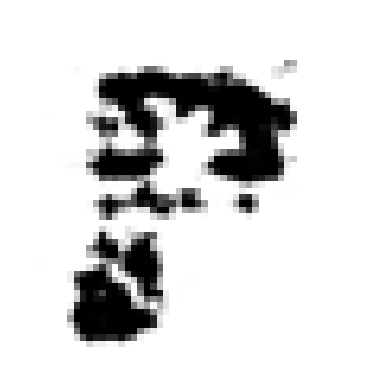

In [112]:
# Open the image
# image = Image.open('/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/output_image.jpg')
path_filled = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/output_image_filled.jpg'


image = Image.open(path_output) # path_filled

# Resize the image to 14x14
image = image.resize((66, 66))

# Convert the image to a numpy array
image_array = np.asarray(image)

# Invert the pixel values
image_array = 1-(image_array / 255.0)

image_array = color.rgb2gray(image_array)

image_array[35:66, 40:66] = 1
image_array[0:10, 0:66] = 1
image_array[0:30, 53:66] = 1

# Display the inverted image
plt.imshow(image_array[2:60,8:64], cmap='gray')
plt.axis('off')
plt.savefig('output_image_enhanced.jpg')
plt.savefig('output_image_enhanced_iterate_0.jpg')

plt.show()


This is the second code block to run if you want to enhance the image further. Here I am using recondtruction to identify holes in the letter. Then instead of just filling those holes, I use inpaint biharmonic to infer the values that should be in that hole. Since the letter P has a big hole in the middle, I dont want to fill it, and inpaint allows me to do just that using its inferencing methods. 

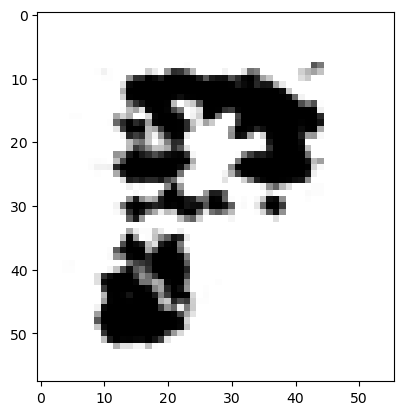

In [113]:
image_filled = rescale_intensity(image_array[2:60,8:64], in_range=(0, 1))

seed = np.copy(image_filled)
seed[1:-1, 1:-1] = image_filled.max()
mask_local = image_filled

filled = reconstruction(seed, mask_local, method='erosion', footprint=square(5))

seed = np.copy(image_filled)
seed[1:-1, 1:-1] = image_filled.min()
rec = reconstruction(seed, mask_local, method='dilation', footprint=square(5))

holes_array = (image_filled - rec)
height, width = holes_array.shape

# Create a new image with double the dimensions
new_height, new_width = height * 1, width * 1

holes_array = cv2.resize(holes_array, (new_width, new_height))

holes_array = 1 - np.where(holes_array > 0, 1, 0)

image_result = inpaint.inpaint_biharmonic(image_filled, (1 - holes_array))**2


plt.imshow(image_result, cmap='gray')

plt.savefig('output_image_filled.jpg', bbox_inches='tight')



Show the holes it finds in each iteration of the processing loop. 

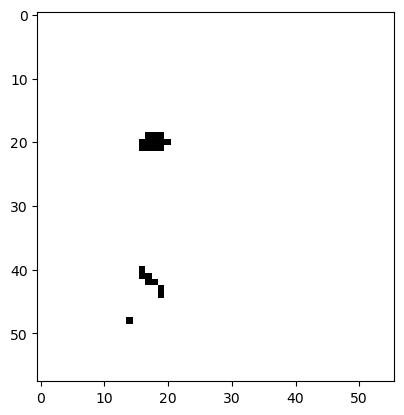

In [114]:
plt.imshow(holes_array, cmap='gray');

Here I am indexing into the letter P's value in the dataframe and then changing the name of it to the image I want to test out. In this case it is the output image filled. 

In [115]:
test_img = info_path_test.iloc[info_path_test.index == 67]
test_img['External ID'] = ['output_image_enhanced.jpg' for x in test_img['External ID']]
test_img

/var/folders/1n/svcs5g6s7mv0fpm0vy7nq6y00000gn/T/ipykernel_23175/3712375560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_img['External ID'] = ['output_image_enhanced.jpg' for x in test_img['External ID']]


,External ID,Description
67,output_image_enhanced.jpg,16


Prep the data for the prediction.

In [116]:
test_generator_output = datagen.flow_from_dataframe(
    dataframe=test_img,
    directory='/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/' ,
    x_col="External ID",
    y_col="Description",
    target_size=(66, 66),
    batch_size=batch_size,
    class_mode='raw',
    shuffle = True
)

Found 1 validated image filenames.


Most of the time it works on its own proper holdout test data

In [117]:
pred_probs = model.predict(test_generator_single)
print(pred_probs)
# Get the predicted class label
pred_label = np.argmax(pred_probs)
print(pred_label)

    
print("The predicted class is:", pred_label)

1/1 [==============================] - 0s 108ms/step
[[6.6890432e-03 2.4275821e-04 8.1358456e-05 4.4190936e-02 1.7101820e-01
  7.0984550e-02 1.0327365e-01 2.6918733e-03 1.1662627e-05 8.5859407e-05
  1.0256254e-01 2.9657449e-05 5.8994210e-05 3.4674191e-05 3.7884969e-02
  3.5961110e-02 7.4176758e-04 4.0760374e-01 1.0092860e-02 9.1530057e-04
  3.2571231e-06 6.4786436e-06 1.0454011e-07 4.8347511e-03]]
17
The predicted class is: 17


letter_bnw_test_61.jpg


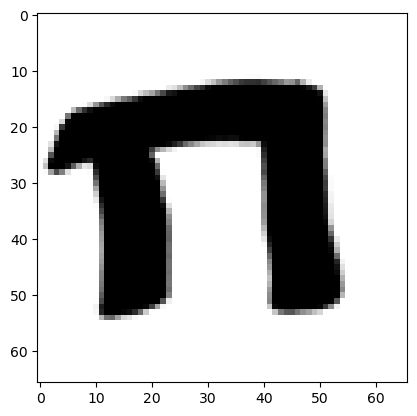

In [118]:
test_pull = info_path_test.loc[info_path_test['Description'] == pred_label]
test_pull = single['External ID'].iloc[0]
print(test_pull)

# data_classifier/test_high_resolution/

test_pull_path = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/test_high_resolution/' + test_pull
test_pull_path

test_image_pull = Image.open(test_pull_path)
# Resize the image to 14x14
test_image_pull = test_image_pull.resize((66, 66))


# Convert the image to a numpy array
test_image_pull = np.asarray(test_image_pull)

# test_image_pull = color.rgb2gray(test_image_pull)

# Invert the pixel values
test_image_pull = (test_image_pull / 255.0)
display(plt.imshow(test_image_pull, cmap='gray'));

letter_bnw_61.jpg


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

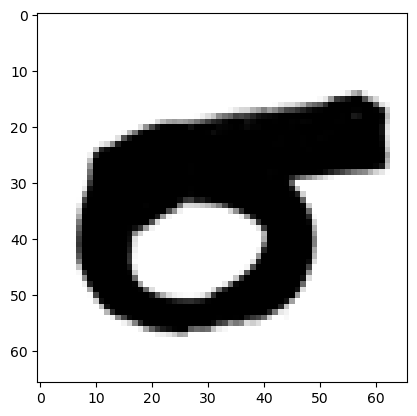

In [119]:
neural_pull = info_path_train.loc[info_path_train['Description'] == pred_label]
neural_pull = neural_pull['External ID'].iloc[0]
print(neural_pull)

neural_pull_path = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/train_high_resolution/' + neural_pull
neural_pull_path


image_pull = Image.open(neural_pull_path)
# Resize the image to 14x14
image_pull = image_pull.resize((66, 66))

# Convert the image to a numpy array
image_pull = np.asarray(image_pull)

display(image_pull)
# Invert the pixel values
image_pull = (image_pull / 255.0)
plt.imshow(image_pull, cmap='gray');

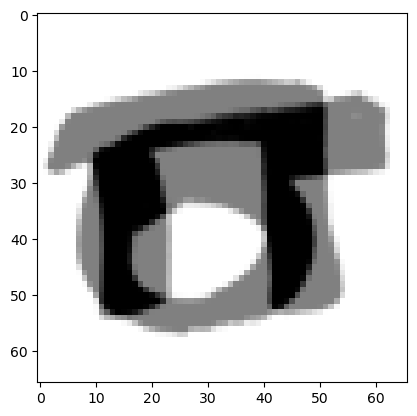

In [120]:
gray_image_pull = np.mean(test_image_pull, axis=-1)

plt.imshow(test_image_pull + image_pull, cmap='gray');

However it struggles to identify the letter P

In [121]:
pred_probs = model.predict(test_generator_output)
print(pred_probs)
# Get the predicted class label
pred_label = np.argmax(pred_probs)
print(pred_label)

    
print("The predicted class is:", pred_label)

1/1 [==============================] - 0s 23ms/step
[[8.0978474e-08 5.4916923e-06 1.9931149e-05 3.5943875e-05 3.5295938e-04
  8.8042597e-04 4.3089520e-03 5.9854519e-05 7.5122880e-05 6.5546026e-03
  4.1203864e-04 1.1554317e-03 1.3258704e-04 3.8496161e-01 6.2437771e-09
  1.8384651e-05 5.1420196e-03 1.1306441e-06 8.7848266e-06 1.1998558e-06
  3.6535598e-02 2.9902485e-01 2.5863197e-01 1.6810558e-03]]
13
The predicted class is: 13


Here I use the network's prediction to pull the corresponding train image it believes most suits the test image. 

letter_bnw_101.jpg


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

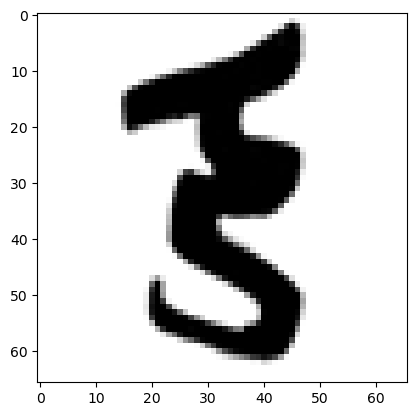

In [122]:
neural_pull = info_path_train.loc[info_path_train['Description'] == pred_label]
neural_pull = neural_pull['External ID'].iloc[0]
print(neural_pull)

neural_pull_path = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/train_high_resolution/' + neural_pull
neural_pull_path


image_pull = Image.open(neural_pull_path)
# Resize the image to 14x14
image_pull = image_pull.resize((66, 66))

# Convert the image to a numpy array
image_pull = np.asarray(image_pull)

display(image_pull)
# Invert the pixel values
image_pull = (image_pull / 255.0)
plt.imshow(image_pull, cmap='gray');

Render the test image

In [123]:
test_img

,External ID,Description
67,output_image_enhanced.jpg,16


output_image_enhanced.jpg


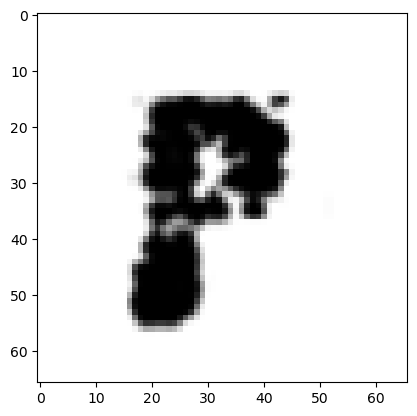

In [124]:
test_pull = info_path_test.loc[info_path_test['Description'] == pred_label]
test_pull = test_img['External ID'].iloc[0]
print(test_pull)

# data_classifier/test_high_resolution/

test_pull_path = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/' + test_pull
test_pull_path

test_image_pull = Image.open(test_pull_path)
# Resize the image to 14x14
test_image_pull = test_image_pull.resize((66, 66))


# Convert the image to a numpy array
test_image_pull = np.asarray(test_image_pull)

# test_image_pull = color.rgb2gray(test_image_pull)

# Invert the pixel values
test_image_pull = (test_image_pull / 255.0)
display(plt.imshow(test_image_pull, cmap='gray'));

Here I am superimposing the image the network thinks is correct over the holdout test image. We can use this later on perhaps as weights to better steer the inpaint biharmonic masking algorithm I defined earlier. 

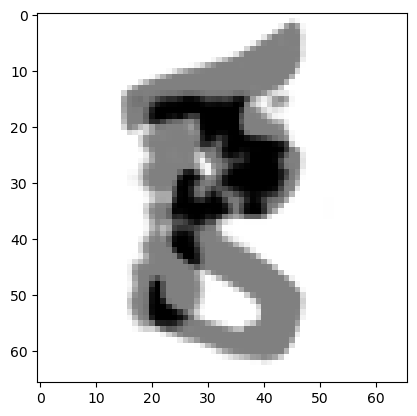

In [125]:
gray_image_pull = np.mean(test_image_pull, axis=-1)

plt.imshow(gray_image_pull + image_pull, cmap='gray');

Quick sanity check to make sure we can render the image from its path. Yes we can. 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


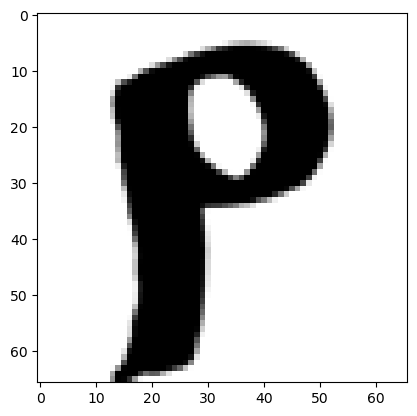

In [126]:
# Open the image
# image = Image.open('/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/output_image.jpg')
image = Image.open(img_path).convert('L')
# Resize the image to 14x14
image = image.resize((66, 66))

# Convert the image to a numpy array
image_array = np.asarray(image)

# Invert the pixel values
image_array = image_array / 255.0

mask = []
for i in range(0,len(image_array)):
    mask_layer = [0 if 'False' else 1 for x in image_array[i]]
    mask.append(mask_layer)

mask = np.array(mask)


mask[35:66, 40:66] = 1
print(mask)

# image_array = [0 if 1 in mask else x for x in image_array]

image_defect = image_array
# image_defect[35:66, 40:66] = 1

# Display the inverted image
plt.imshow(image_defect, cmap='gray')
plt.show()
